<a href="https://colab.research.google.com/github/YangruiLin620/ITSModel/blob/main/%E2%80%9CITS_SecondModelData_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入数据并进行数据预处理

In [18]:
from google.colab import files
import io
import pandas as pd
from sklearn.model_selection import KFold  # 导入KFold
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# 上传文件
uploaded = files.upload()

# 假设上传的文件名为 'data.csv'
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving NewModelData.csv to NewModelData (6).csv


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from scipy import stats

# 简单的线性插值来生成新数据点
new_data = []
for _ in range(100):  # 生成100个新数据点
    idx1, idx2 = np.random.choice(len(df), 2, replace=False)
    alpha = np.random.uniform(0.3, 0.7)  # 插值系数
    new_point = df.iloc[idx1] * alpha + df.iloc[idx2] * (1 - alpha)
    new_data.append(new_point)
df_augmented = pd.concat([df] + new_data, ignore_index=True)

# 假设 df 是你的 DataFrame
# 定义特征列
features = df[['AnbiTemp', 'ObjTemp', 'Absorbance', 'OptiPath']]

# 计算Z得分并移除异常值
z_scores = np.abs(stats.zscore(features))
outliers_z = np.where(z_scores > 2.5)
df_cleaned = df.drop(index=outliers_z[0])

# 使用隔离森林进一步检测异常值
iso_forest = IsolationForest(n_estimators=100, contamination=0.01)
iso_forest.fit(df_cleaned[features.columns])  # 确保使用带有特征名称的 DataFrame
outliers_iso = iso_forest.predict(df_cleaned[features.columns]) == -1

# 更新 DataFrame，移除被隔离森林识别的异常值
df_cleaned['outlier'] = outliers_iso
df_cleaned = df_cleaned[df_cleaned['outlier'] == False].copy()
df_cleaned.drop(columns='outlier', inplace=True)

# 数据标准化
scaler = StandardScaler()
df_cleaned[features.columns] = scaler.fit_transform(df_cleaned[features.columns])

# 建立自编码器模型
input_dim = features.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(10, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 训练自编码器
autoencoder.fit(df_cleaned[features.columns], df_cleaned[features.columns], epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

# 预测并计算重构误差
reconstructions = autoencoder.predict(df_cleaned[features.columns])
mse = np.mean(np.power(df_cleaned[features.columns] - reconstructions, 2), axis=1)
mse_threshold = np.percentile(mse, 95)
outliers_ae = mse > mse_threshold

# 标记并移除自编码器识别的异常值
df_cleaned['outlier'] = outliers_ae
df_final = df_cleaned[df_cleaned['outlier'] == False].copy()
df_final.drop(columns='outlier', inplace=True)


# 检查缺失值
if df.isnull().any().any():
    df.fillna(df.mean(), inplace=True)  # 用平均值填充缺失值

# 处理 AnbiTemp 和 ObjTemp，放大变化
scaler_temp = StandardScaler()
df[['AnbiTemp', 'ObjTemp']] = scaler_temp.fit_transform(df[['AnbiTemp', 'ObjTemp']])
scale_factor = 20  # 定义放大系数
df[['AnbiTemp', 'ObjTemp']] *= scale_factor

# 归一化其他特征
scaler_other = MinMaxScaler()
df[['Absorbance', 'OptiPath']] = scaler_other.fit_transform(df[['Absorbance', 'OptiPath']])

# 数据增强 - 添加小的随机噪声
noise_factor = 0.02  # 噪声系数
df[['Absorbance', 'OptiPath']] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=df[['Absorbance', 'OptiPath']].shape)

# 添加交互项和非线性特征
df['AnbiTemp_Squared'] = df['AnbiTemp'] ** 2
df['ObjTemp_Squared'] = df['ObjTemp'] ** 2
df['Absorbance_Squared'] = df['Absorbance'] ** 2
df['OptiPath_Squared'] = df['OptiPath'] ** 2
df['AnbiTemp_ObjTemp_Interaction'] = df['AnbiTemp'] * df['ObjTemp']
df['AnbiTemp_Absorbance_Interaction'] = df['AnbiTemp'] * df['Absorbance']
df['ObjTemp_Absorbance_Interaction'] = df['ObjTemp'] * df['Absorbance']
df['AnbiTemp_OptiPath_Interaction'] = df['AnbiTemp'] * df['OptiPath']
df['ObjTemp_OptiPath_Interaction'] = df['ObjTemp'] * df['OptiPath']

# 设置X和y
X = df.drop(['AlcoholConcentration'], axis=1)

y = df['AlcoholConcentration']

# KFold
kf = KFold(n_splits=10)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


9/9 [==============================] - 0s 2ms/step


神经网络模型 - 贝叶斯优化后

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold


# 从贝叶斯优化中获取最优参数
optimal_learning_rate = 0.004260456319815208
optimal_n_neurons = 50

for fold_var, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 使用最优参数构建模型
    nn_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(optimal_n_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(1)  # 假设是回归问题
    ])

    # 使用最优学习率
    optimizer = tf.keras.optimizers.Adam(learning_rate=optimal_learning_rate)

    # 编译模型
    nn_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # 训练模型，使用早停来防止过拟合
    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=0)

    # 评估模型
    _, nn_mae = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f'Fold {fold_var} - Neural Network Test MAE: {nn_mae:.4f}')

    # 清除 TensorFlow 图来帮助减少内存使用
    tf.keras.backend.clear_session()


Fold 1 - Neural Network Test MAE: 6.3077
Fold 2 - Neural Network Test MAE: 3.5336
Fold 3 - Neural Network Test MAE: 18.5576
Fold 4 - Neural Network Test MAE: 34.2973
Fold 5 - Neural Network Test MAE: 6.3840
Fold 6 - Neural Network Test MAE: 13.2155


随机森林回归器 - 进过贝叶斯优化后

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # 导入 RandomForestRegressor
from sklearn.model_selection import GroupKFold

for fold_var, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 应用最佳参数
    rf_model = RandomForestRegressor(
        n_estimators=270,  # 最佳树的数量
        max_depth=33,  # 最佳的最大深度
        min_samples_leaf=5,  # 最佳的最小叶子节点样本数
        min_samples_split=15 # 最佳的最小分裂所需样本数
    )
    rf_model.fit(X_train_scaled, y_train)

    rf_preds = rf_model.predict(X_test_scaled)
    rf_mae = np.mean(np.abs(rf_preds - y_test))
    print(f'Fold {fold_var} - Random Forest Test MAE: {rf_mae:.4f}')


Fold 1 - Random Forest Test MAE: 8.5405
Fold 2 - Random Forest Test MAE: 4.0218
Fold 3 - Random Forest Test MAE: 6.2174
Fold 4 - Random Forest Test MAE: 14.1004
Fold 5 - Random Forest Test MAE: 5.0944
Fold 6 - Random Forest Test MAE: 11.4404


套索回归 Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

# GroupKFold交叉验证
for fold_var, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups), start=1):
    # 根据划分的索引来分割数据
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 初始化并训练套索回归模型
    lasso_reg = Lasso(alpha=0.005622117123602399, max_iter=1000000)
    lasso_reg.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred = lasso_reg.predict(X_test)

    # 计算并输出每个fold的MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Fold {fold_var} - Lasso Regression Test MAE: {mae:.4f}')


Fold 1 - Lasso Regression Test MAE: 11.5080
Fold 2 - Lasso Regression Test MAE: 5.0147
Fold 3 - Lasso Regression Test MAE: 6.2398
Fold 4 - Lasso Regression Test MAE: 12.9060
Fold 5 - Lasso Regression Test MAE: 6.0955
Fold 6 - Lasso Regression Test MAE: 12.1013


弹性网回归 Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

# GroupKFold交叉验证
for fold_var, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups), start=1):
    # 根据划分的索引来分割数据
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 初始化并训练弹性网回归模型
    elastic_net_reg = ElasticNet(alpha=0.005622117123602399, l1_ratio=0.5, max_iter=1000000)

    elastic_net_reg.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred = elastic_net_reg.predict(X_test)

    # 计算并输出每个fold的MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Fold {fold_var} - Elastic Net Regression Test MAE: {mae:.4f}')

Fold 1 - Elastic Net Regression Test MAE: 12.1136
Fold 2 - Elastic Net Regression Test MAE: 3.5960
Fold 3 - Elastic Net Regression Test MAE: 7.0073
Fold 4 - Elastic Net Regression Test MAE: 22.6933
Fold 5 - Elastic Net Regression Test MAE: 5.4363
Fold 6 - Elastic Net Regression Test MAE: 14.2653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+03, tolerance: 2.063e+01
  model = cd_fast.enet_coordinate_descent(


模型融合: NN, RF, LassoR, ENR

2/2 [==============================] - 0s 7ms/step


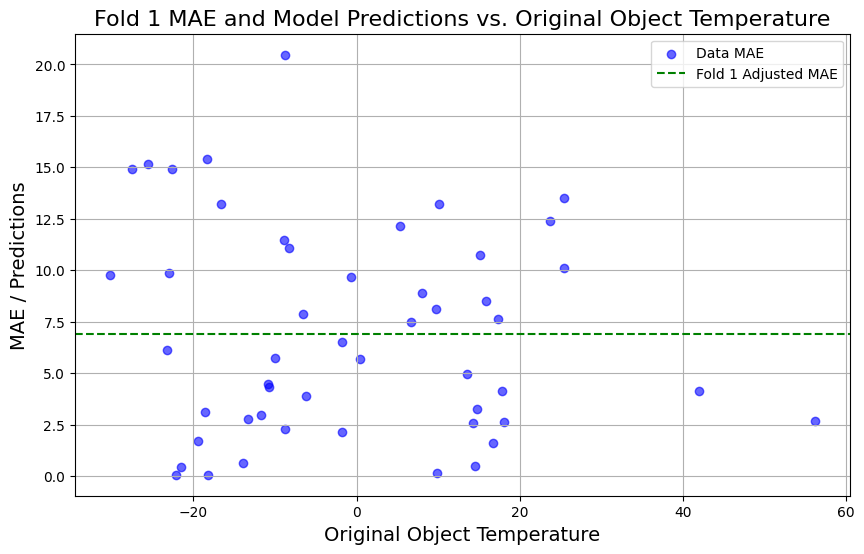

2/2 [==============================] - 0s 7ms/step


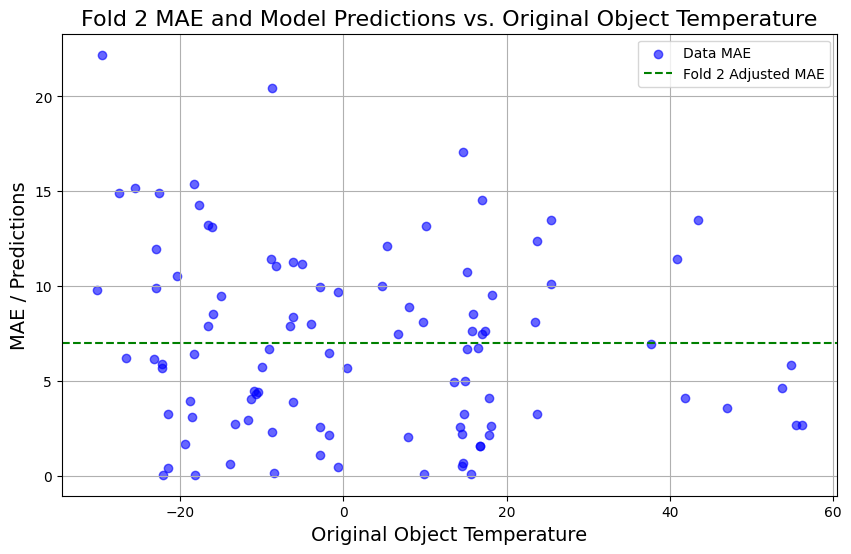

2/2 [==============================] - 0s 10ms/step


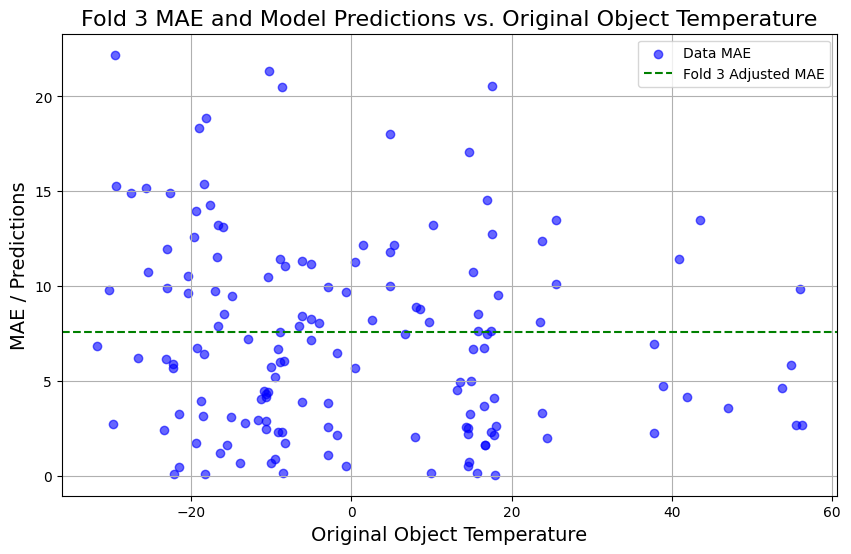

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold  # 使用KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
import tensorflow as tf
import matplotlib.pyplot as plt

data_maes = []  # 用于存储每个数据点的MAE
data_temps = []  # 用于存储每个数据点的温度
ensemble_maes = []  # 用于存储每个fold的融合模型MAE
adjusted_ensemble_maes = []  # 用于存储每个fold的调整后融合模型MAE
average_obj_temps_per_fold = []  # 初始化用于存储每个fold的平均对象温度的列表

kf = KFold(n_splits=6, shuffle=True, random_state=42)

for fold_var, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 神经网络模型
    nn_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(1)
    ])
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.004260456319815208), loss='mean_squared_error')
    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=0)
    nn_preds = nn_model.predict(X_test_scaled).flatten()
    tf.keras.backend.clear_session()

    # 随机森林模型
    rf_model = RandomForestRegressor(n_estimators=270, max_depth=33, min_samples_leaf=5, min_samples_split=15)
    rf_model.fit(X_train_scaled, y_train)
    rf_preds = rf_model.predict(X_test_scaled)

    # 套索回归模型
    lasso_reg = Lasso(alpha=0.005622117123602399, max_iter=1000000)
    lasso_reg.fit(X_train, y_train)
    lasso_preds = lasso_reg.predict(X_test)

    # 弹性网回归模型
    elastic_net_reg = ElasticNet(alpha=0.005622117123602399, l1_ratio=0.5, max_iter=1000000)
    elastic_net_reg.fit(X_train, y_train)
    elastic_preds = elastic_net_reg.predict(X_test)

    # 原始融合预测结果和MAE
    ensemble_preds = (nn_preds + rf_preds + lasso_preds + elastic_preds) / 4
    ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
    ensemble_maes.append(ensemble_mae)

    # 调整权重后的融合预测结果和MAE
    rf_weight = 0.5
    ls_weight = 0.2
    nn_weight = 0.2
    enr_weight = 0.1
    adjusted_ensemble_preds = (nn_preds * nn_weight + rf_preds * rf_weight + lasso_preds * ls_weight + elastic_preds * enr_weight)
    adjusted_ensemble_mae = mean_absolute_error(y_test, adjusted_ensemble_preds)
    adjusted_ensemble_maes.append(adjusted_ensemble_mae)

    # 计算并存储当前fold的ObjTemp的平均值
    average_obj_temp = X_test['ObjTemp'].mean()
    average_obj_temps_per_fold.append(average_obj_temp)

    # 计算每个数据点的MAE并存储
    for i, idx in enumerate(test_index):
        data_mae = np.abs(y_test.iloc[i] - adjusted_ensemble_preds[i])
        data_maes.append(data_mae)
        data_temps.append(X.iloc[idx]['ObjTemp'])

    # 绘制模型预测曲线
    plt.figure(figsize=(10, 6))
    plt.scatter(data_temps, data_maes, label='Data MAE', color='blue', alpha=0.6)
    plt.axhline(y=adjusted_ensemble_mae, color='green', linestyle='--', label=f'Fold {fold_var} Adjusted MAE')
    plt.xlabel('Original Object Temperature', fontsize=14)
    plt.ylabel('MAE / Predictions', fontsize=14)
    plt.title(f'Fold {fold_var} MAE and Model Predictions vs. Original Object Temperature', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# 输出调整权重后的融合模型平均MAE
average_adjusted_ensemble_mae = np.mean(adjusted_ensemble_maes)
print(f'Average Adjusted Ensemble Model MAE: {average_adjusted_ensemble_mae:.4f}')
